# Facial Expression Recognition

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os

from tensorflow import keras
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Add, BatchNormalization, Activation, Dropout, PReLU
from keras.regularizers import l1, l2, l1_l2
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
df = {}
for expression in os.listdir("train/"):
    directory = "train/" + expression
    df[expression] = len(os.listdir(directory))
df = pd.DataFrame(df, index=[0])

In [4]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory("train/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

test_generator = test_datagen.flow_from_directory("test/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Building Block for res-Net
def convolution_block(feed, f1, f2, f):
    shortcut =  feed
    
    # For the convolutional part
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", activation = 'relu', kernel_regularizer=l2(1e-4))(feed)
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", kernel_regularizer=l2(1e-4))(mix)

    # For the shortcut path
    # X_shortcut = Conv2D(filters = f1, kernel_size=(1,1), padding = "Same",kernel_regularizer=l2(1e-4))(X_shortcut)

    mix = Add()([shortcut,mix])
    mix = PReLU(alpha_initializer='zeros')(mix)

    mix = Conv2D(filters = f2, activation = 'relu', kernel_size=(f,f), padding = "Valid", kernel_regularizer=l2(1e-4))(mix)
    
    return mix

# ResNet Model


In [4]:
# Building Block for res-Net
def convolution_block(feed, f1, f2, f):
    shortcut =  feed
    
    # For the convolutional part
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", activation = 'relu', kernel_regularizer=l2(1e-4))(feed)
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", kernel_regularizer=l2(1e-4))(mix)

    # For the shortcut path
    # X_shortcut = Conv2D(filters = f1, kernel_size=(1,1), padding = "Same",kernel_regularizer=l2(1e-4))(X_shortcut)

    mix = Add()([shortcut,mix])
    mix = PReLU(alpha_initializer='zeros')(mix)

    mix = Conv2D(filters = f2, activation = 'relu', kernel_size=(f,f), padding = "Same", kernel_regularizer=l2(1e-4))(mix)
    
    return mix

In [5]:
def archi3(input_shape=(48,48,1), classes=7):
    X_input = Input(input_shape)

    # Convolution Layer-1 to output 24*24*16
    X = Conv2D(filters=16, kernel_size=(5,5),activation = 'relu', padding="Same", kernel_regularizer=l2(1e-4))(X_input)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)
    
    # ResNet Layer-1 to output 12*12*32
    X = convolution_block(feed=X, f1=16, f2=32, f = 3)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    # ResNet Layer-2 to output 6*6*64
    X = convolution_block(feed=X, f1=32, f2=64, f = 3)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    # Convolution Layer-2 to output 2*2*128
    X = Conv2D(filters=128, kernel_size=(3,3),activation = 'relu', padding="Valid", kernel_regularizer=l2(1e-4))(X)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    X = Flatten()(X)

    X = Dropout(0.5)(X)
    X = Dense(128,activation = 'relu', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization()(X)
    X_output = Dense(classes, activation = 'softmax')(X)

    model = Model(X_input, X_output)

    return model

In [6]:
model5 = archi3(input_shape = (48,48,1), classes = 7)
model5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 16)   64          max_pooling2d[0][0]              
_______________________________________________________________________________________

In [7]:
model5.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001,decay=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-7) , metrics=["accuracy"])
history5 = model5.fit(train_generator,shuffle=True, batch_size=batch_size, epochs=50, validation_data=test_generator, validation_steps = 113)

Epoch 1/50
449/449 [==============================] - 94s 208ms/step - loss: 1.9156 - accuracy: 0.2601 - val_loss: 1.9119 - val_accuracy: 0.2646
Epoch 2/50
449/449 [==============================] - 91s 202ms/step - loss: 1.6786 - accuracy: 0.3612 - val_loss: 1.5717 - val_accuracy: 0.4053
Epoch 3/50
449/449 [==============================] - 94s 209ms/step - loss: 1.5578 - accuracy: 0.4165 - val_loss: 1.5187 - val_accuracy: 0.4295
Epoch 4/50
449/449 [==============================] - 93s 206ms/step - loss: 1.4811 - accuracy: 0.4510 - val_loss: 1.4286 - val_accuracy: 0.4713
Epoch 5/50
449/449 [==============================] - 92s 206ms/step - loss: 1.4235 - accuracy: 0.4738 - val_loss: 1.3997 - val_accuracy: 0.4797
Epoch 6/50
449/449 [==============================] - 95s 211ms/step - loss: 1.3895 - accuracy: 0.4884 - val_loss: 1.3896 - val_accuracy: 0.4965
Epoch 7/50
449/449 [==============================] - 93s 207ms/step - loss: 1.3543 - accuracy: 0.5057 - val_loss: 1.3774 - val_ac

In [11]:
score5 = model5.evaluate(test_generator, verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

Test loss: 1.1485953330993652
Test accuracy: 0.6129841208457947


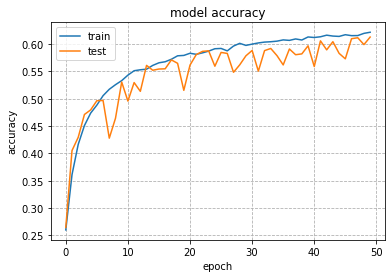

In [12]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

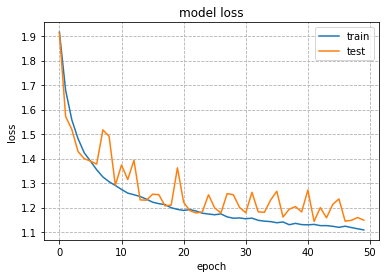

In [13]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Summary

| Model                                   |      Accuracy after 50 epoches     | Loss after 50 epoches |
| :-------------------------------------: | :--------------------------------: | :-------------------: |
| ....................................... | .................................. | ..................... |
|Convolutional Neural Network (CNN)       | 61.298%                            | 1.14859               |
|Residual Neural Network (ResNet)         | 61.033%                            | 1.03836               |